In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
import model

from importlib import reload
from itertools import product
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [6]:
reload(wrangle)

<module 'wrangle' from '/Users/sinao/codeup-data-science/unemployment_project/wrangle.py'>

In [102]:
reload(model)

<module 'model' from '/Users/sinao/codeup-data-science/unemployment_project/model.py'>

In [8]:
df = wrangle.prep_aug()

/Users/sinao/codeup-data-science/unemployment_project/wrangle.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[np.where(df.peafnow == 1)]['peafever'] = 1
/Users/sinao/codeup-data-science/unemployment_project/wrangle.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.pehrftpt == 1]['pehruslt'] = more_than_35
/Users/sinao/codeup-data-science/unemployment_project/wrangle.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [9]:
train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle.split_scale(df, 'y')

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28450 entries, 26127 to 19091
Columns: 171 entries, household_num to occupation_11.0
dtypes: float64(7), int64(9), uint8(155)
memory usage: 7.9 MB


# Setup
Explore various models and feature combinations.
Choose **three** models to validate. Choose **one** to test. 
Artifact: `model.py`

### Modeling Preparation
> Create Baseline prediction and accuracy
* Place results in dataframe that features model description for addtion of later models --> `model_descriptions`
> Create dataframe model evaluation metrics --> move to `model.py`
* `comparision_chart`
> Create functions to  --> move to `model.py`
> update dataframes with each model in turn
> create visualization of each model's accuracy

### Baseline Prediction and Accuracy

In [11]:
# formulate baseline prediction
train.employed.value_counts(normalize=True)

1    0.962882
0    0.037118
Name: employed, dtype: float64

In [62]:
def split_X_y(df):
    # split data into Big X, small y sets 
    X_train = train.drop(columns=['employed'])
    y_train = train.employed

    X_validate = validate.drop(columns=['employed'])
    y_validate = validate.employed

    X_test = test.drop(columns=['employed'])
    y_test = test.employed

    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [243]:
def compute_metrics(model, X_df, y_df):
    """
    purpose: function executes performs computations to produce evaulation metrics for a given model

    inputs: 
        model: a model that has been previous fit to spec
        X_df: a dataframe featuring the X subset of data for evaluation
        y_df: a dataframe featuring the model target variable

    Returns: a rounded pandas Series that can be adding to an evaulation metric comparison chart
    """
    # Make Predictions
    y_pred = model.predict(X_df)

    # Estimate Probability 
    y_pred_proba = model.predict_proba(X_df)

    #create confusion matrix
    confusion = confusion_matrix(y_df, y_pred)

    #assign results of confusion matrix to variables
    true_negative = confusion[0,0]
    false_positive = confusion[0,1]
    false_negative = confusion[1,0]
    true_positive = confusion[1,1]

    #accuracy
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    #true positive rate / recall
    recall = true_positive / (true_positive +false_negative)

    #false positive rate
    false_positive_rate = false_positive / (true_negative + false_positive)

    #true negative rate
    true_negative_rate = true_negative / (true_negative + false_positive)

    #false negative rate
    false_negative_rate = false_negative / (false_negative + true_positive)

    #precision
    precision = true_positive / (true_positive + false_positive)

    #f1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    #support
    support_positive = true_positive + false_negative
    support_negative = false_positive + true_negative

    metrics = pd.Series([accuracy, true_positive, false_positive, true_negative, false_negative,\
                        recall, false_positive_rate, true_negative_rate, false_negative_rate, \
                        precision, f1_score, support_positive, support_negative])
                        
    return metrics.round(4)

In [ ]:
def create_comp_chart():
    """
    purpose: to create a dataframe with an index reflecting compuation metrics for future models

    returns: a pandas dataframe with appropriately set index
    """
    statistics = ['Accuracy/Score',
    'True Positives' , 'False Positives', 'True Negatives', 'False Negatives', \
    'TPR/Recall', 'False Positive Rate', 'True Negative Rate', 'False Negative Rate', \
    'Precision', 'F1-Score', 'Support Positive', 'Support Negative']


    return pd.DataFrame({}, index=statistics)

In [12]:
# split data into Big X, small y sets 
X_train = train.drop(columns=['employed'])
y_train = train.employed

X_validate = validate.drop(columns=['employed'])
y_validate = validate.employed

X_test = test.drop(columns=['employed'])
y_test = test.employed


In [13]:
# formulate baseline accuracy
baseline_accuracy = (y_train == 1).mean()

print(f'Baseline Accuracy for \"unemployed\" prediction: {(baseline_accuracy * 100): .3}%')

Baseline Accuracy for "unemployed" prediction on Telco dataset:  96.3%


In [239]:
def create_description_chart(y):

    # formulate baseline accuracy
    baseline_accuracy = (y == 1).mean()

    descriptions = pd.DataFrame({'Model': 'Baseline', \
                                'Accuracy(Score)': baseline_accuracy,
                                'Type': 'Basic Baseline',
                                'Features Used': 'Baseline Prediction',
                                'Parameters': 'n/a'
                                }, index=[0])
    
    return descriptions

In [15]:
model_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0])

In [16]:
pd.concat([model_descriptions, pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0]) ], ignore_index=True)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.962882,Basic Baseline,Baseline Prediction,n/a
1,Baseline,0.962882,Basic Baseline,Baseline Prediction,n/a


In [17]:
comparison_chart = model.create_comp_chart()

# Models

## Decision Tree

In [18]:
feat_set = ['marital_status', 'occupation', 'race', 'education', 'citizenship']

In [228]:
subsets = [train, X_train, y_train]

In [229]:
def model_dtc(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product(np.arange(20,25,2)))

    for idx, item in enumerate(selectors):
        model_id = 'DTC_'+f'{idx}'
        dtc = DecisionTreeClassifier(max_depth=item[0],\
                                            random_state=514)
        
        dtc.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(dtc, X_train[features], y_train).values

        score = dtc.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Decision Tree Classifier',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}'},
                                    index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [230]:
model_descriptions, comparison_chart =  model_dtc(feat_set, model_descriptions, comparison_chart, subsets)

In [231]:
model_descriptions

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.962882,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.968200,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20
2,DTC_1,0.968200,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 22
3,DTC_2,0.968200,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 24
4,RF_5,0.968200,Random Forest,"['marital_status', 'occupation', 'race', 'educ...","Depth: 25, Leaves: 1"
5,Knn_1,0.936450,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 1
6,Knn_2,0.927140,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 2
7,Knn_3,0.963660,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 3
8,Knn_4,0.963130,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 4
9,Knn_5,0.966680,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 5


## Random Forest

In [255]:
def model_rf(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product([20,25], [3,2,1]))

    for idx, item in enumerate(selectors):
        model_id = 'RF_'+f'{idx}'
        rf = RandomForestClassifier(max_depth=item[0],\
                                            min_samples_leaf=item[1],
                                            random_state=514)
        
        rf.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(rf, X_train[features], y_train).values

        score = rf.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Random Forest',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}, Leaves: {item[1]}'},
                                    index=[0])
       
    model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [23]:
model_descriptions, comparison_chart = model_rf(feat_set, model_descriptions, comparison_chart)

### Takeaways - Random Forest
* 

## KNN (K-Nearest Neighbors)

In [254]:
## K-Nearest Neighbors
def model_knn(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    k_range = range(1, 15)
    scores = []
    
    for k in k_range:
        
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[features], y_train)
        scores.append(knn.score(X_train[features], y_train))

        model_id = 'Knn_'+f'{k}'

        comparison_chart[model_id] = model.compute_metrics(knn, X_train[features], y_train).values

        score = knn.score(X_train[features], y_train).round(5)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Knn',
            'Features Used': f'{feat_set}',
            'Parameters': f'K-Neighbors: {k}'},
            index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)
   
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.scatter(k_range, scores)
    plt.xticks([0,5,10,15,20])
    plt.show()
    np.mean(scores)

    
    return model_descriptions, comparison_chart

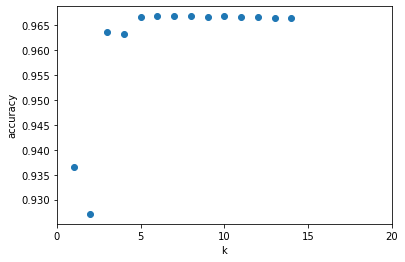

In [25]:
model_descriptions, comparison_chart = model_knn(feat_set, model_descriptions, comparison_chart)

In [26]:
model_descriptions.sort_values(by='Accuracy(Score)', ascending=False).head()

,Model,Accuracy(Score),Type,Features Used,Parameters
0,DTC_1,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 22
0,DTC_2,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 24
0,RF_5,0.96820,Random Forest,"['marital_status', 'occupation', 'race', 'educ...","Depth: 25, Leaves: 1"
0,DTC_0,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20
0,Knn_7,0.96675,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 7


## Logistic Regression

In [253]:
def model_lr(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    cees = [.1,.5,1]
    solver = ['newton-cg', 'lbfgs']
    weights = [None, 'balanced']

    selectors = list(product(cees, solver, weights))

    for idx, item in enumerate(selectors):
        model_id = 'LR_'+f'{idx}'
        lr = LogisticRegression(C=item[0],\
                                solver=item[1],
                                class_weight=item[2],
                                max_iter=400,
                                random_state=514)
        
        lr.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(lr, X_train[features], y_train).values

        score = lr.score(X_train[features], y_train).round(4)

        model_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Logistic Regression',
            'Features Used': f'{feat_set}',
            'Parameters': f'C: {item[0]}, Solver: {item[1]}, Class Weight: {item[2]}'
        }

    return model_descriptions, comparison_chart

In [28]:
model_descriptions, comparison_chart = model_lr(feat_set, model_descriptions, comparison_chart)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Model Description and Comparison Charts


In [29]:
model_descriptions.groupby('Type')['Accuracy(Score)'].mean()

Type
Basic Baseline              0.962882
Decision Tree Classifier    0.968200
Knn                         0.961197
Logistic Regression         0.806528
Random Forest               0.968200
Name: Accuracy(Score), dtype: float64

In [30]:
#model descriptions
model_descriptions.sort_values('Accuracy(Score)', ascending=False).head(20)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,DTC_0,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20
0,DTC_1,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 22
0,DTC_2,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 24
0,RF_5,0.96820,Random Forest,"['marital_status', 'occupation', 'race', 'educ...","Depth: 25, Leaves: 1"
9,LR_8,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.5, Solver: lbfgs, Class Weight: None"
17,LR_16,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 1, Solver: sag, Class Weight: None"
15,LR_14,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 1, Solver: lbfgs, Class Weight: None"
5,LR_4,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.1, Solver: sag, Class Weight: None"
11,LR_10,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.5, Solver: sag, Class Weight: None"
3,LR_2,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.1, Solver: lbfgs, Class Weight: None"


In [31]:
comparison_chart.T.sort_values(by='True Negatives', ascending=False).head(25).sort_values(by=['Accuracy/Score'])

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
LR_17,0.4936,13491.0,504.0,552.0,13903.0,0.4925,0.4773,0.5227,0.5075,0.9640,0.6519,27394.0,1056.0
LR_5,0.6577,18074.0,419.0,637.0,9320.0,0.6598,0.3968,0.6032,0.3402,0.9773,0.7878,27394.0,1056.0
LR_3,0.6577,18074.0,419.0,637.0,9320.0,0.6598,0.3968,0.6032,0.3402,0.9773,0.7878,27394.0,1056.0
LR_1,0.6577,18074.0,419.0,637.0,9320.0,0.6598,0.3968,0.6032,0.3402,0.9773,0.7878,27394.0,1056.0
LR_15,0.6581,18086.0,418.0,638.0,9308.0,0.6602,0.3958,0.6042,0.3398,0.9774,0.7881,27394.0,1056.0
LR_13,0.6581,18086.0,418.0,638.0,9308.0,0.6602,0.3958,0.6042,0.3398,0.9774,0.7881,27394.0,1056.0
LR_9,0.6582,18089.0,418.0,638.0,9305.0,0.6603,0.3958,0.6042,0.3397,0.9774,0.7882,27394.0,1056.0
LR_7,0.6583,18091.0,418.0,638.0,9303.0,0.6604,0.3958,0.6042,0.3396,0.9774,0.7882,27394.0,1056.0
LR_11,0.7088,19651.0,541.0,515.0,7743.0,0.7173,0.5123,0.4877,0.2827,0.9732,0.8259,27394.0,1056.0
Knn_2,0.9271,26117.0,796.0,260.0,1277.0,0.9534,0.7538,0.2462,0.0466,0.9704,0.9618,27394.0,1056.0


In [32]:
comparison_chart.T.sort_values(by='Accuracy/Score', ascending=False).head(25).sort_values(by=['False Positives'])

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
DTC_0,0.9682,27379.0,889.0,167.0,15.0,0.9995,0.8419,0.1581,0.0005,0.9686,0.9838,27394.0,1056.0
DTC_2,0.9682,27379.0,889.0,167.0,15.0,0.9995,0.8419,0.1581,0.0005,0.9686,0.9838,27394.0,1056.0
DTC_1,0.9682,27379.0,889.0,167.0,15.0,0.9995,0.8419,0.1581,0.0005,0.9686,0.9838,27394.0,1056.0
RF_2,0.9682,27390.0,900.0,156.0,4.0,0.9999,0.8523,0.1477,0.0001,0.9682,0.9838,27394.0,1056.0
RF_5,0.9682,27390.0,900.0,156.0,4.0,0.9999,0.8523,0.1477,0.0001,0.9682,0.9838,27394.0,1056.0
LR_2,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0
RF_0,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0
RF_1,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0
RF_3,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0
RF_4,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0


## Model Creation Takeaways
* The Decision Tree and Logistic Regression models did not perform well 
* Best Models are D, G, I 
* Got rid of sag solver for lr models. coefficients not converging

## Model Validation
* Goal:
    - Create function based on reading data from model_scores dframe into variables that will create the parameters for the compute_metrics function.  
    - This will allow iterative testing on the train set, and auto-filterting for the validate testing

In [33]:
# #scratch work
# model_descriptions.iloc[1]['Features Used'].strip('\[]\'').split('\', \'')
# for idx in model_descriptions.index:
#     print(model_descriptions.iloc[idx]['Features Used'])
# model_descriptions.iloc[1]['Parameters'].split(',')
# your_string = model_descriptions.iloc[1]['Parameters']
# removal_list = ['Depth: ',' Leaves: ','C: ','Solver: ']

# for word in removal_list:
#     your_string = your_string.replace(word, "")

# your_string.split(',')

# top_20.iloc[0]['Features Used'].strip('\[]\'').split('\', \'')

In [34]:
top_20 = model_descriptions.sort_values('Accuracy(Score)', ascending=False).head(20)

In [35]:
def get_selectors(parameters):
    removal_list = ['Depth: ','K-Neighbors: ','Leaves: ','C: ',' Solver: ', ' Class Weight: ']

    for word in removal_list:
        parameters = parameters.replace(word, "")

    return parameters.split(',')

In [261]:
def score_on_validation(descriptions, subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate= subsets[3]
    y_validate = subsets[4]

    
    validate_metrics = create_comp_chart()
    val_descriptions = create_description_chart(y_validate)
    
    #feat_set = descriptions.iloc[1]['Features Used'].strip('\[]\'').split('\', \'')
    print(descriptions.index)
    for idx in descriptions.index:

        model_id = descriptions.loc[idx]['Model']
        feat_set = descriptions.loc[idx]['Features Used'].strip('\[]\'').split('\', \'')
        selectors = get_selectors(descriptions.loc[idx]['Parameters'])

        features = []

        for feature in feat_set:
            features += [col for col in train.columns if feature in col]

        if model_id.startswith('DTC'):
            val_model = DecisionTreeClassifier(max_depth=int(selectors[0]),\
                                                random_state=514)
        elif model_id.startswith('RF'):
            val_model = RandomForestClassifier(max_depth=int(selectors[0]),\
                                            min_samples_leaf=int(selectors[1]),
                                            random_state=514)
        elif model_id.startswith('Knn'):
            val_model = KNeighborsClassifier(n_neighbors = int(selectors[0]))
        elif model_id.startswith('LR'):
            val_model = LogisticRegression(C=float(selectors[0]),\
                                            solver=selectors[1],
                                            class_weight=selectors[2],
                                            max_iter=200,
                                            random_state=514)  
                                    
        val_model.fit(X_train[features], y_train)

        validate_metrics[model_id] = model.compute_metrics(val_model, X_validate[features], y_validate).values

        score = val_model.score(X_validate[features], y_validate).round(4)

        val_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': descriptions.loc[idx]['Type'],
            'Features Used': f'{feat_set}',
            'Parameters': descriptions.loc[idx]['Parameters']
        }
        
    val_descriptions.insert(loc=2, column='Sensitivity', value=0)

    for idx in val_descriptions.index:
        model_id = val_descriptions.loc[idx]['Model']
        if model_id != 'Baseline':
            val_descriptions.loc[idx, 'Sensitivity'] = validate_metrics.T.loc[model_id]['True Negative Rate']        


    return val_descriptions, validate_metrics

In [39]:
val_descriptions, validate_metrics = score_on_validation(top_20)

In [40]:
val_descriptions

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.962933,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.966500,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20
10,LR_2,0.968300,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.1, Solver: lbfgs, Class Weight: None"
18,Knn_5,0.967100,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 5
16,Knn_10,0.967100,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 10
6,LR_16,0.968300,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 1, Solver: sag, Class Weight: None"
12,LR_0,0.968300,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.1, Solver: newton-cg, Class Weight: None"
4,RF_5,0.967900,Random Forest,"['marital_status', 'occupation', 'race', 'educ...","Depth: 25, Leaves: 1"
14,Knn_8,0.967200,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 8
2,DTC_1,0.966500,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 22


In [41]:
validate_metrics.T.sort_values(by='True Negative Rate', ascending=False)

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
DTC_0,0.9665,11718.0,384.0,68.0,24.0,0.9980,0.8496,0.1504,0.0020,0.9683,0.9829,11742.0,452.0
DTC_1,0.9665,11718.0,384.0,68.0,24.0,0.9980,0.8496,0.1504,0.0020,0.9683,0.9829,11742.0,452.0
RF_5,0.9679,11737.0,386.0,66.0,5.0,0.9996,0.8540,0.1460,0.0004,0.9682,0.9836,11742.0,452.0
LR_2,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_16,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_0,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_4,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
Knn_5,0.9671,11740.0,399.0,53.0,2.0,0.9998,0.8827,0.1173,0.0002,0.9671,0.9832,11742.0,452.0
Knn_8,0.9672,11742.0,400.0,52.0,0.0,1.0000,0.8850,0.1150,0.0000,0.9671,0.9833,11742.0,452.0
Knn_10,0.9671,11742.0,401.0,51.0,0.0,1.0000,0.8872,0.1128,0.0000,0.9670,0.9832,11742.0,452.0


### Takeaways
> Initial: All three chosen sets perform baseline. Need to re-adjust and re-attempt

In [42]:
top_model = val_descriptions[val_descriptions.Model == 'DTC_0']

In [47]:
top_model

,Model,Accuracy(Score),Type,Features Used,Parameters
1,DTC_0,0.9665,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20


In [54]:
for idx in top_model.index:
    print(top_model.loc[idx]['Model'])

DTC_0


In [241]:
def score_on_test(descriptions, subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_test = subsets[5]
    y_test = subsets[6]

    test_metrics = create_comp_chart()
    test_descriptions = create_description_chart(y_test)
        
    for idx in descriptions.index:
        
        model_id = descriptions.loc[idx]['Model']
        feat_set = descriptions.loc[idx]['Features Used'].strip('\[]\'').split('\', \'')
        selectors = get_selectors(descriptions.loc[idx]['Parameters'])

        features = []

        for feature in feat_set:
            features += [col for col in train.columns if feature in col]

        if model_id.startswith('DTC'):
            test_model = DecisionTreeClassifier(max_depth=int(selectors[0]),\
                                                random_state=514)
        elif model_id.startswith('RF'):
            test_model = RandomForestClassifier(max_depth=int(selectors[0]),\
                                            min_samples_leaf=int(selectors[1]),
                                            random_state=514)
        elif model_id.startswith('Knn'):
            test_model = KNeighborsClassifier(n_neighbors = int(selectors[0]))
        elif model_id.startswith('LR'):
            test_model = LogisticRegression(C=float(selectors[0]),\
                                            solver=selectors[1],
                                            class_weight=selectors[2],
                                            max_iter=200,
                                            random_state=514)  
                                    
        test_model.fit(X_train[features], y_train)

        test_metrics[model_id] = compute_metrics(test_model, X_test[features], y_test).values

        score = test_model.score(X_test[features], y_test).round(4)

        test_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': descriptions.loc[idx]['Type'],
            'Features Used': f'{feat_set}',
            'Parameters': descriptions.loc[idx]['Parameters']
        }

    return test_descriptions, test_metrics


In [60]:
test_descriptions, test_metrics = score_on_test(top_model)

In [61]:
test_metrics

,DTC_0
Accuracy/Score,0.9663
True Positives,9771.0000
False Positives,328.0000
True Negatives,49.0000
False Negatives,14.0000
TPR/Recall,0.9986
False Positive Rate,0.8700
True Negative Rate,0.1300
False Negative Rate,0.0014
Precision,0.9675


In [63]:
def create_comp_chart():
    """
    purpose: to create a dataframe with an index reflecting compuation metrics for future models

    returns: a pandas dataframe with appropriately set index
    """
    statistics = ['Accuracy/Score',
    'True Positives' , 'False Positives', 'True Negatives', 'False Negatives', \
    'TPR/Recall', 'False Positive Rate', 'True Negative Rate', 'False Negative Rate', \
    'Precision', 'F1-Score', 'Support Positive', 'Support Negative']


    return pd.DataFrame({}, index=statistics)

In [257]:
def train_models(X, y, feature_groups, subsets):
    
   #take in features sets and run them through each of the different types
   #of models and their variations
   train_descriptions = create_description_chart(y)
   train_metrics = create_comp_chart()

   for features in feature_groups:
      
      train_descriptions, train_metrics = model_dtc(features, train_descriptions, train_metrics, subsets)
      train_descriptions, train_metrics = model_rf(features, train_descriptions, train_metrics, subsets)
      #train_descriptions, train_metrics = model_knn(features, train_descriptions, train_metrics, subsets)
      train_descriptions, train_metrics = model_lr(features, train_descriptions, train_metrics, subsets)

   train_descriptions.insert(loc=2, column='Sensitivity', value=0)

   for idx in train_descriptions.index:
      model_id = train_descriptions.iloc[idx]['Model']
      if model_id != 'Baseline':
         train_descriptions.loc[idx, 'Sensitivity'] = train_metrics.T.loc[model_id]['True Negative Rate']
         
   return train_descriptions, train_metrics

In [250]:
def for_final_report(train, feature_bank):

    X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train)

    subsets=[train, X_train, y_train, X_validate, y_validate, X_test, y_test]

    train_descriptions, train_metrics = train_models(X_train, y_train, feature_bank, subsets)

    train_descriptions[train_descriptions.Sensitivity > .20].\
        sort_values('Accuracy(Score)', ascending=False).\
        head(20)

    top_4 = train_descriptions[train_descriptions.Sensitivity > .20].\
        sort_values('Accuracy(Score)', ascending=False).\
        head(4)

    val_descriptions, validate_metrics = score_on_validation(top_4, subsets)

    top_1 = val_descriptions[(val_descriptions.Sensitivity > .20) & (val_descriptions['Accuracy(Score)'] > .66)].\
        sort_values('Sensitivity', ascending=False).\
        head(1)

    test_descriptions, test_metrics = score_on_test(top_1, subsets)

    return test_metrics

In [262]:
for_final_report(train, [feat_set])

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Int64Index([12, 8, 10, 14], dtype='int64')


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,LR_7
Accuracy/Score,0.6684
True Positives,6554.0000
False Positives,139.0000
True Negatives,238.0000
False Negatives,3231.0000
TPR/Recall,0.6698
False Positive Rate,0.3687
True Negative Rate,0.6313
False Negative Rate,0.3302
Precision,0.9792
